In [1]:
import sys
sys.path.append('../')

In [2]:
from IPython.display import display, HTML
from tft.data import DataLoader
from tft.config import read_config

In [3]:
cfg = read_config('../../config.yaml')

In [4]:
dt = DataLoader(data_dir=cfg.scrape.data_dir).load_all()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.45s/it]


In [5]:
dt.participants.index.nunique()

25136

In [6]:
dt.participants

last_round  \
match_id       puuid                                                            
NA1_4430293510 3NgqyD3JthZUd6Zpb8fDn6KEohJPyuTRnjmLla43jtHaieJ...          31   
               diTsaz_luHEPXsBkgWQdudwHMokfcI7RuSHhie92DIj8WpM...          35   
               ENVRzEuKrmQkvtk-MWZAWPqKhi-oE1vfqAxZHaPNZroCl8U...          38   
               dDcTYaq9itKPKe4CUX8Agn7Ct5KwOqIwTqfs3GnHH5cPlZa...          23   
               LQSRJLV9dpPWfpo6TVNfAoTpBu7s46Sr5uVJjUuVh60kS79...          33   
...                                                                       ...   
NA1_4431003316 uXC_J-bHfiSWmYuDFgnUNrIaMGzCsO7kgT797hCJjN5PG4S...          30   
               tdJCeeBG3y0ve5xOH9maFaKIjOSSqoha7rOnTylylVdLy6E...          30   
               GWHOPAPXSjA6RY8ChWwQRrYut2mx3Sg1-lW0Eo2OgdMgBTB...          31   
               h36mtX0Yt7TZUzqxpwPlt1X_5BfCsw4rgDP0_t4iMXI140r...          28   
               xRlB5o_OaU9WhqS_JgYMKnRndOVEWBdkBRDc_0lspl5pcs2...          24   

                                                                   level  \
match_id       puuid                                                       
NA1_4430293510 3NgqyD3JthZUd6Zpb8fDn6KEohJPyuTRnjmLla43jtHaieJ...      8   
               diTsaz_luHEPXsBkgWQdudwHMokfcI7RuSHhie92DIj8WpM...      9   
               ENVRzEuKrmQkvtk-MWZAWPqKhi-oE1vfqAxZHaPNZroCl8U...      9   
               dDcTYaq9itKPKe4CUX8Agn7Ct5KwOqIwTqfs3GnHH5cPlZa...      6   
               LQSRJLV9dpPWfpo6TVNfAoTpBu7s46Sr5uVJjUuVh60kS79...      8   
...                                                                  ...   
NA1_4431003316 uXC_J-bHfiSWmYuDFgnUNrIaMGzCsO7kgT797hCJjN5PG4S...      8   
               tdJCeeBG3y0ve5xOH9maFaKIjOSSqoha7rOnTylylVdLy6E...      8   
               GWHOPAPXSjA6RY8ChWwQRrYut2mx3Sg1-lW0Eo2OgdMgBTB...      9   
               h36mtX0Yt7TZUzqxpwPlt1X_5BfCsw4rgDP0_t4iMXI140r...      8   
               xRlB5o_OaU9WhqS_JgYMKnRndOVEWBdkBRDc_0lspl5pcs2...      7   

                                                                   total_damage_to_players  \
match_id       puuid                                                                         
NA1_4430293510 3NgqyD3JthZUd6Zpb8fDn6KEohJPyuTRnjmLla43jtHaieJ...                       45   
               diTsaz_luHEPXsBkgWQdudwHMokfcI7RuSHhie92DIj8WpM...                      122   
               ENVRzEuKrmQkvtk-MWZAWPqKhi-oE1vfqAxZHaPNZroCl8U...                      132   
               dDcTYaq9itKPKe4CUX8Agn7Ct5KwOqIwTqfs3GnHH5cPlZa...                       13   
               LQSRJLV9dpPWfpo6TVNfAoTpBu7s46Sr5uVJjUuVh60kS79...                       83   
...                                                                                    ...   
NA1_4431003316 uXC_J-bHfiSWmYuDFgnUNrIaMGzCsO7kgT797hCJjN5PG4S...                       86   
               tdJCeeBG3y0ve5xOH9maFaKIjOSSqoha7rOnTylylVdLy6E...                      102   
               GWHOPAPXSjA6RY8ChWwQRrYut2mx3Sg1-lW0Eo2OgdMgBTB...                       98   
               h36mtX0Yt7TZUzqxpwPlt1X_5BfCsw4rgDP0_t4iMXI140r...                       74   
               xRlB5o_OaU9WhqS_JgYMKnRndOVEWBdkBRDc_0lspl5pcs2...                       30   

                                                                   placement  \
match_id       puuid                                                           
NA1_4430293510 3NgqyD3JthZUd6Zpb8fDn6KEohJPyuTRnjmLla43jtHaieJ...          6   
               diTsaz_luHEPXsBkgWQdudwHMokfcI7RuSHhie92DIj8WpM...          3   
               ENVRzEuKrmQkvtk-MWZAWPqKhi-oE1vfqAxZHaPNZroCl8U...          2   
               dDcTYaq9itKPKe4CUX8Agn7Ct5KwOqIwTqfs3GnHH5cPlZa...          8   
               LQSRJLV9dpPWfpo6TVNfAoTpBu7s46Sr5uVJjUuVh60kS79...          5   
...                                                                      ...   
NA1_4431003316 uXC_J-bHfiSWmYuDFgnUNrIaMGzCsO7kgT797hCJjN5PG4S...          5   
               tdJCeeBG3y0ve5xOH9maFaKIjOSSqoha7rOnTylylVdLy6E...          4   
 

In [7]:
def winrate(x):
    return x.where(x == True).count() / x.count()

def true_count(x):
    return x.where(x == True).count()

def total_perc(total):
    return lambda x: x.count() / total

def winrate_for(df, group: str, cutoff = 1, perc_cutoff = 0.01):
    df['winrate'] = df['placement'] <= cutoff
    df['win'] = df['placement'] <= cutoff
    df['loss'] = df['placement'] >= cutoff
    df['total_perc'] = 1
    cnt = len(df)
    wr = df.groupby(group).agg({
        'winrate': winrate,
        'win': true_count, 'loss': true_count,
        'total_perc': total_perc(cnt),
    })
    return wr[wr['total_perc'] > perc_cutoff].sort_values(by=['winrate'], ascending=False)
    

In [8]:
player_winrate = winrate_for(dt.participants, 'puuid', perc_cutoff = 0.00001)

In [9]:
mn = player_winrate['winrate'].mean()
HTML(f"Mean player winrate <strong>{round(mn * 100, 2)}%</strong>")

<AxesSubplot:xlabel='character_id'>

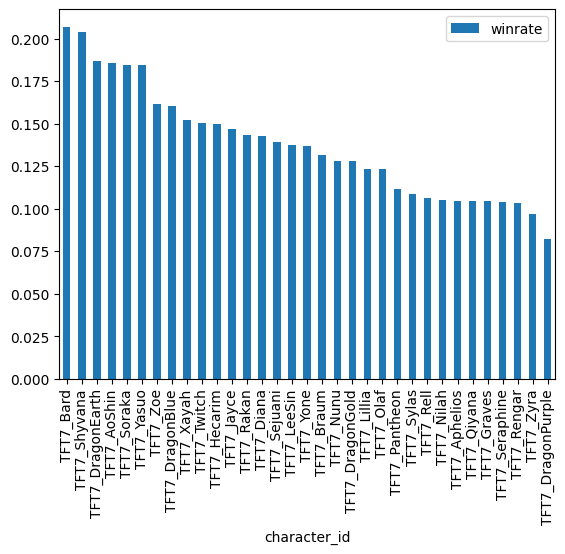

In [10]:
winrate_for(dt.units, 'character_id')[['winrate']].plot(kind='bar')

<AxesSubplot:xlabel='item'>

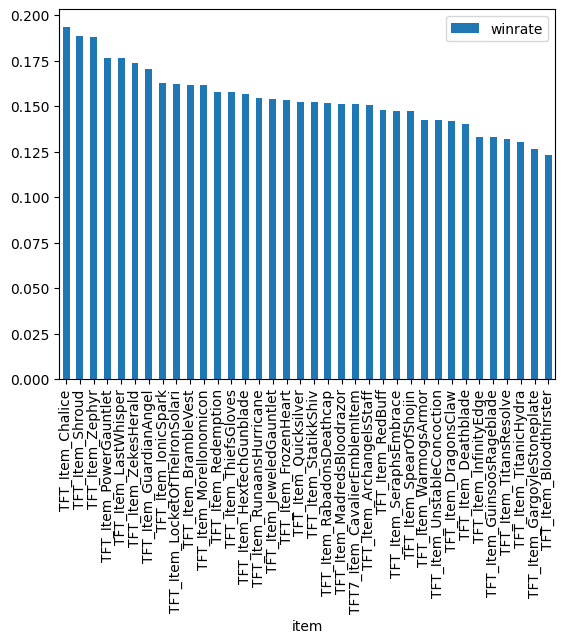

In [11]:
winrate_for(dt.items, 'item')[['winrate']].plot(kind='bar')

<AxesSubplot:xlabel='augment'>

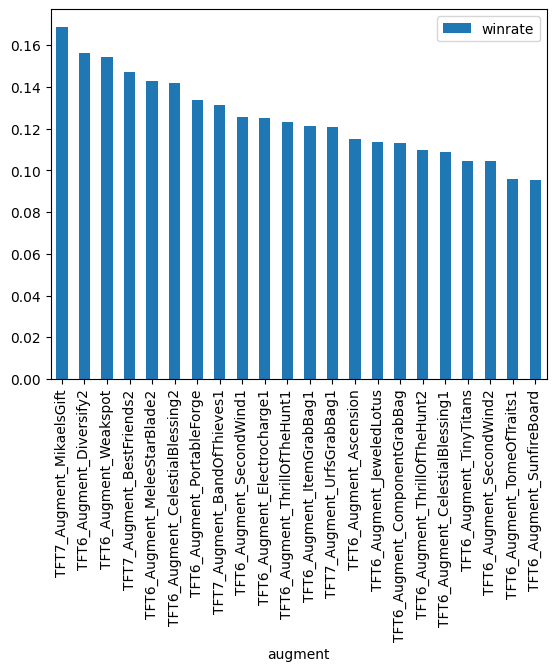

In [12]:
winrate_for(dt.augments, 'augment')[['winrate']].plot(kind='bar')

<AxesSubplot:xlabel='character_id'>

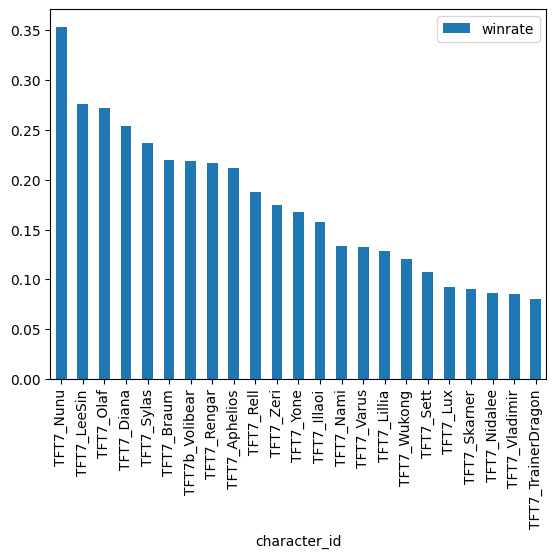

In [13]:
star3_df = dt.units.loc[:][dt.units['tier'] == 3]
winrate_for(star3_df, 'character_id')[['winrate']].plot(kind='bar')

<AxesSubplot:xlabel='character_id,item'>

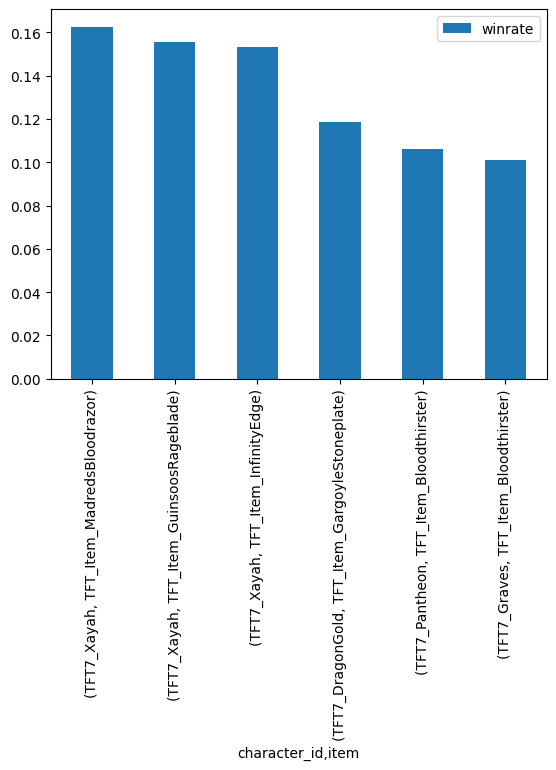

In [14]:
winrate_for(dt.items, ['character_id', 'item'], perc_cutoff = 0.005)[['winrate']].plot(kind='bar')